In [1]:
# 🧬 VARIATIONAL AUTOENCODER IN PYTORCH
# ============================================================
# GOAL: Learn a structured latent space by reconstructing images
# while regularizing the distribution over latent vectors.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set reproducibility
torch.manual_seed(42)

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: flatten image → hidden → (mu, logvar)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder: latent z → hidden → reconstructed image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()  # output pixel probabilities in [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # epsilon ~ N(0, I)
        return mu + std * eps

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [3]:
def vae_loss(x_hat, x, mu, logvar):
    # Reconstruction loss (BCE between input and output)
    recon_loss = F.binary_cross_entropy(x_hat, x.view(-1, 28*28), reduction='sum')

    # KL divergence between q(z|x) and p(z) ~ N(0, I)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = vae_loss(x_hat, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Avg Loss = {avg_loss:.2f}")

Epoch 1, Avg Loss = 190.94
Epoch 2, Avg Loss = 168.88
Epoch 3, Avg Loss = 164.26
Epoch 4, Avg Loss = 161.94
Epoch 5, Avg Loss = 160.27
Epoch 6, Avg Loss = 158.81
Epoch 7, Avg Loss = 157.52
Epoch 8, Avg Loss = 156.39
Epoch 9, Avg Loss = 155.37
Epoch 10, Avg Loss = 154.47


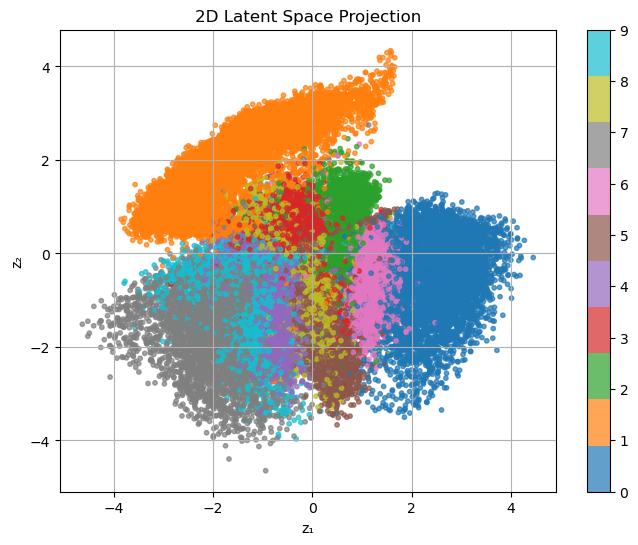

In [5]:
# Project data to 2D latent space
model.eval()
all_z = []
all_labels = []
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu = model.fc_mu(model.encoder(x))
        all_z.append(mu.cpu())
        all_labels.append(y)

z = torch.cat(all_z)
labels = torch.cat(all_labels)

plt.figure(figsize=(8,6))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="tab10", alpha=0.7, s=10)
plt.colorbar()
plt.title("2D Latent Space Projection")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()

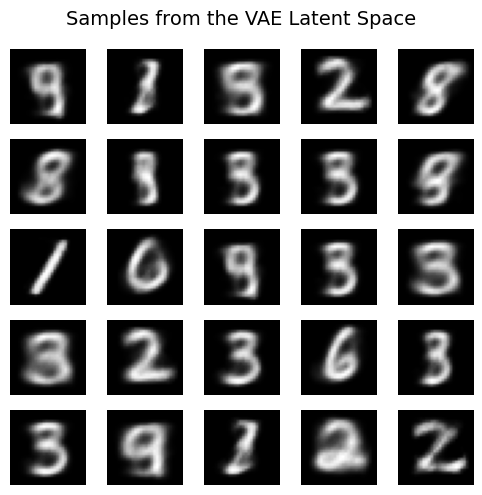

In [6]:
# Sample from the prior p(z) ~ N(0, I) and decode to generate digits
def sample_and_plot(model, n_rows=5, n_cols=5):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_rows * n_cols, model.latent_dim).to(device)
        generated = model.decoder(z).view(-1, 1, 28, 28).cpu()

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].imshow(generated[i * n_cols + j][0], cmap='gray')
            axs[i, j].axis('off')

    plt.suptitle("Samples from the VAE Latent Space", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run it
sample_and_plot(model, n_rows=5, n_cols=5)

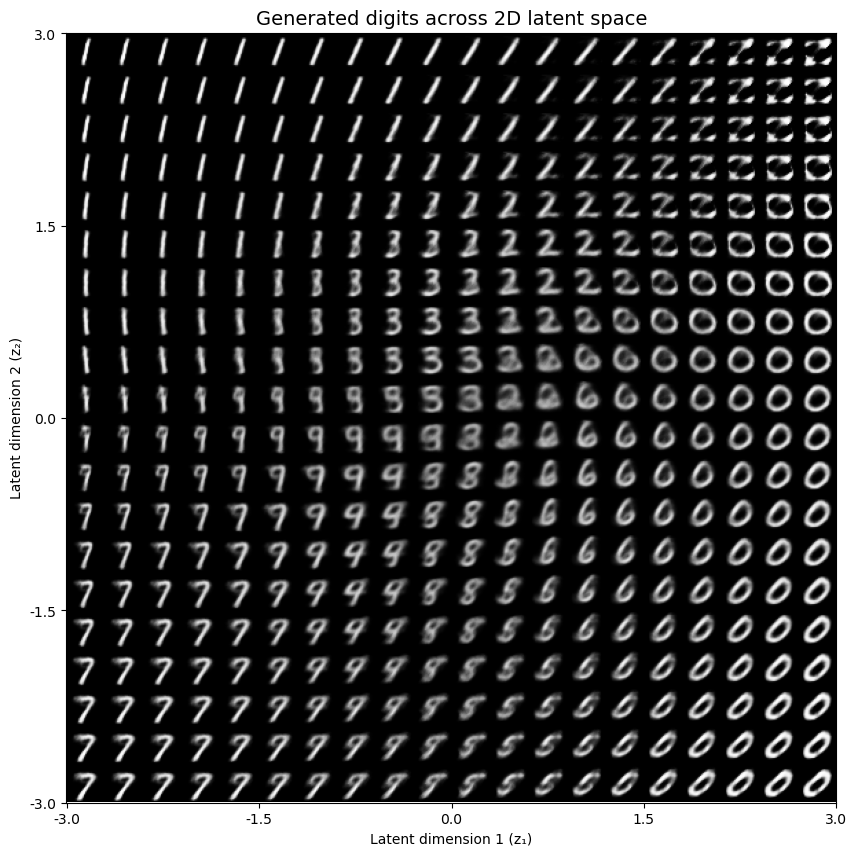

In [7]:
def plot_latent_grid_with_data(model, n=20, range_lim=3.0):
    model.eval()
    with torch.no_grad():
        # Create grid of latent vectors
        grid_x = np.linspace(-range_lim, range_lim, n)
        grid_y = np.linspace(-range_lim, range_lim, n)
        z_grid = torch.tensor([[x, y] for y in reversed(grid_y) for x in grid_x], dtype=torch.float32).to(device)
        samples = model.decoder(z_grid).view(-1, 1, 28, 28).cpu()

    # Plot generated digits from the latent grid
    fig, ax = plt.subplots(figsize=(10, 10))
    canvas = np.zeros((28 * n, 28 * n))
    for i, yi in enumerate(reversed(grid_y)):
        for j, xi in enumerate(grid_x):
            digit = samples[i * n + j][0]
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = digit.numpy()

    ax.imshow(canvas, cmap='gray')
    ax.set_title("Generated digits across 2D latent space", fontsize=14)
    ax.set_xlabel("Latent dimension 1 (z₁)")
    ax.set_ylabel("Latent dimension 2 (z₂)")
    ax.set_xticks(np.linspace(0, 28*n, 5))
    ax.set_xticklabels([f"{x:.1f}" for x in np.linspace(-range_lim, range_lim, 5)])
    ax.set_yticks(np.linspace(0, 28*n, 5))
    ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(range_lim, -range_lim, 5)])
    plt.grid(False)
    plt.show()

plot_latent_grid_with_data(model, n=20, range_lim=3.0)